/var/folders/15/7vdcd9756072lbp614rqt18c0000gn/T/ipykernel_9097/370161684.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  posterior = torch.load("saved_models/trained_s

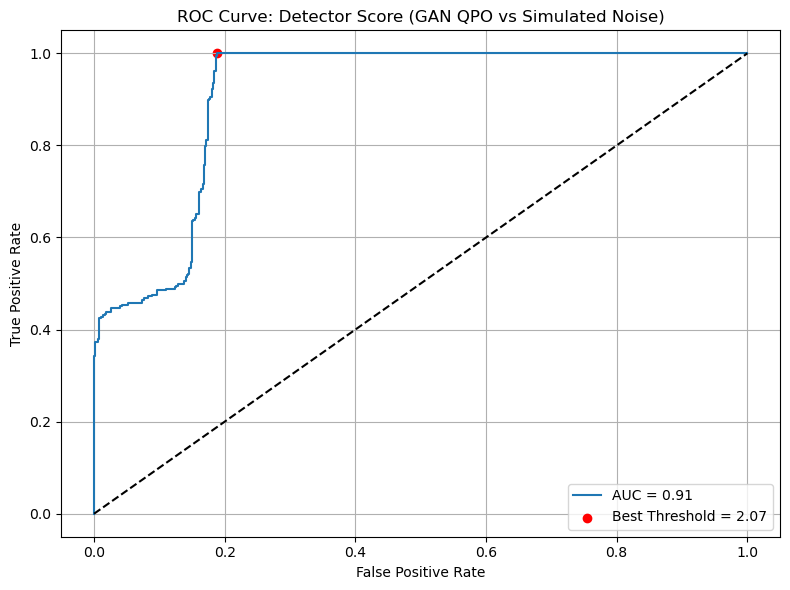

Best Score Threshold: 2.07
AUC: 0.91


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import torch
from scipy.signal import welch
from scipy.optimize import curve_fit
from tensorflow.keras.models import load_model
import tensorflow as tf

# --- Load Models ---
generator = load_model("../saved_models/generator_final.keras")
posterior = torch.load("../saved_models/trained_sbi_posterior.pt")

# --- Lorentzian ---


def lorentzian(f, A, f0, gamma):
    return A / (1 + ((f - f0) / gamma)**2)


def compute_lorentzian_q(series, fs=1.0, f_window=(0.001, 0.5)):
    try:
        f, Pxx = welch(series.squeeze(), fs=fs, nperseg=256)
        mask = (f > f_window[0]) & (f < f_window[1])
        f_peak, Pxx_peak = f[mask], Pxx[mask]
        p0 = [np.max(Pxx_peak), f_peak[np.argmax(Pxx_peak)], 0.01]
        popt, _ = curve_fit(lorentzian, f_peak, Pxx_peak, p0=p0, maxfev=5000)
        A, f0, gamma = popt
        if gamma <= 0 or f0 <= 0:
            return 0.0
        return f0 / gamma
    except:
        return 0.0

# --- Detector ---


def detect_qpo_sbi(curve, posterior, fs=1.0):
    f, Pxx = welch(curve.squeeze(), fs=fs, nperseg=256)
    x_obs = torch.tensor(Pxx, dtype=torch.float32)
    samples = posterior.sample((500,), x=x_obs, show_progress_bars=False)
    fc_samples, amp_samples = samples[:, 0].numpy(), samples[:, 1].numpy()
    fc_std = fc_samples.std()
    amp_mean = amp_samples.mean()
    Q = compute_lorentzian_q(curve, fs=fs)
    score = np.log1p(Q) + amp_mean - fc_std
    return {
        "Q": Q,
        "fc_std": fc_std,
        "amp_mean": amp_mean,
        "score": score
    }

# --- Light Curve Simulator for non-QPO ---


def simulate_black_hole_lightcurve(fs, fc, fm, qpo_amplitude, duration,
                                   noise_mean=0, noise_std=0.5,
                                   include_qpo=True, modulation_index=0.5):
    t = np.arange(0, duration, 1/fs)
    white_noise = np.random.normal(noise_mean, noise_std, size=len(t))
    white_noise = np.exp(white_noise)
    if include_qpo and qpo_amplitude > 0:
        msg = qpo_amplitude * np.cos(2 * np.pi * fm * t)
        carrier = qpo_amplitude * np.cos(2 * np.pi * fc * t)
        qpo = carrier * (1 + modulation_index * msg / qpo_amplitude)
    else:
        qpo = 0
    flux = white_noise + qpo
    return t, (flux - np.mean(flux)) / np.std(flux)


# --- Config ---
latent_dim = 100
fs = 1.0
duration = 512
num_samples = 500
fc_range = (0.01, 0.5)
amp_range = (0.6, 1.0)

# --- Collect Results ---
results = []

# QPO from GAN
for _ in range(num_samples):
    z = tf.random.normal((1, latent_dim))
    fc = np.random.uniform(*fc_range)
    amp = np.random.uniform(*amp_range)
    label = tf.convert_to_tensor([[fc, amp]], dtype=tf.float32)
    signal = generator([z, label], training=False).numpy().squeeze()
    res = detect_qpo_sbi(signal, posterior, fs=fs)
    if res["Q"] < 3 or res["amp_mean"] < 0.7:
        continue
    res["true_qpo"] = 1
    results.append(res)

# Non-QPO from simulator
for _ in range(num_samples):
    fc = np.random.uniform(*fc_range)
    fm = np.random.uniform(0.005, 0.1)
    amp = np.random.uniform(*amp_range)
    _, flux = simulate_black_hole_lightcurve(
        fs, fc, fm, amp, duration, include_qpo=False)
    res = detect_qpo_sbi(flux, posterior, fs=fs)
    res["true_qpo"] = 0
    results.append(res)

# --- Evaluate ---
df = pd.DataFrame(results)
fpr, tpr, thresholds = roc_curve(df["true_qpo"], df["score"])
roc_auc = auc(fpr, tpr)
j_scores = tpr - fpr
best_idx = np.argmax(j_scores)
best_threshold = thresholds[best_idx]

# --- Plot ---
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.scatter(fpr[best_idx], tpr[best_idx], color='red',
            label=f"Best Threshold = {best_threshold:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: Detector Score (GAN QPO vs Simulated Noise)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("qpo_roc_curve.png")
plt.show()

# --- Print Results ---
print(f"Best Score Threshold: {best_threshold:.2f}")
print(f"AUC: {roc_auc:.2f}")

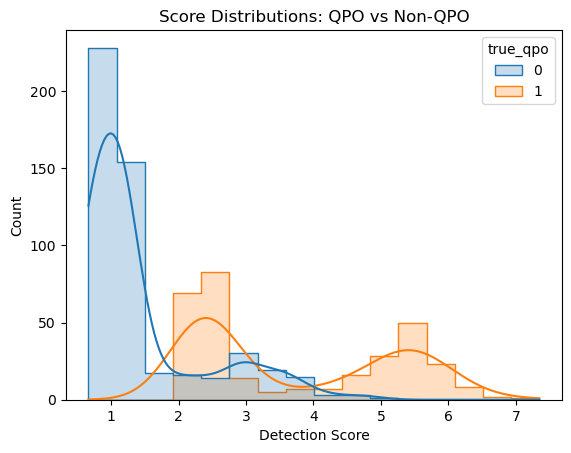

In [5]:
import seaborn as sns
sns.histplot(data=df, x="score", hue="true_qpo", kde=True, element="step")
plt.title("Score Distributions: QPO vs Non-QPO")
plt.xlabel("Detection Score")
plt.ylabel("Count")
plt.show()
